## HeatMap + Prediction - inception_Resnet_V2

In [1]:
from keras.models import load_model
from tensorflow import keras
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
from PIL import Image

## 모델 불러오기

In [6]:
model = load_model('../image_models/3class/covid_model_size299_best_new.h5')
feature_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                                        weights="imagenet")

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.layers import Input

# checkpoint_path = '/content/drive/My Drive/인공지능 학습관련/covid19_detection_model_2'

# def create_model():
#     input = Input(shape=feature_model.output.shape[1:])

#     x = GlobalAveragePooling2D()(input)

#     x = Dense(512, activation='relu')(x)

#     x = tf.keras.layers.Dropout(0.5)(x)

#     predictions = Dense(3, activation='softmax')(x)

#     model = Model(inputs=input, outputs=predictions)
#     model.compile(tf.optimizers.RMSprop(0.0001), 
#                 loss = 'categorical_crossentropy',
#                 metrics=['accuracy'])
#     return model

# model2 = create_model()
# # 가중치 로드
# model2.load_weights(checkpoint_path)
# model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 1536) 0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1539      
Total params: 788,483
Trainable params: 788,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model2 = load_model('/content/drive/My Drive/인공지능 학습관련/covid_model_size299_best.h5')
# # feature_model2 = load_model('/content/drive/My Drive/인공지능 학습관련/feature_model299.h5')

## 함수들

In [20]:
# 이미지 전처리
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224*224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

#  히트맵 생성
def make_gradcam_heatmap(img_path, classifier_model, last_conv_layer_model):
    img_size = (299, 299)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))


    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        print(preds)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]
        print(top_class_channel)

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    print(grads)
    # print(top_class_channel.shape, last_conv_layer_output.shape)
    # print(grads.shape)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # 보정 -- 이미지의 최 외곽부 모두 0
    a = np.vstack((np.zeros(heatmap[:1].shape),heatmap[1:-1]))
    a = np.vstack((a[:-1],np.zeros(heatmap[-1:].shape)))
    for i in a:
        i[0] = 0
        i[-1] = 0
    heatmap = a

    return heatmap

# 감마보정
# gamma correction 
def gamma_correction(img, c=1, g=2.2): 
    out = img.copy() 
    out /= 255. 
    out = (1/c * out) ** (1/g) 
    out *= 255 
    out = out.astype(np.uint8) 
    return out 

# CAM이미지 + 원본
def show_CAM(img_path, heatmap, prediction):
    # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # gamma correction
    jet_heatmap = gamma_correction(jet_heatmap, g=2.2)

    # Superimpose the heatmap on original image
    if prediction =='NORMAL':
        superimposed_img = img
    else:
        superimposed_img = jet_heatmap *0.5 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# 예측함수
# opencv의 resize에서 오류가 발생하여 keras.preprocessing.image의 함수들을 사용하였다.
def predict_CXR(image_path):

    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
    
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)

    # feature_model에서 feature 추출
    feature_vector = feature_model.predict(img)
    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    # print(prediction)
    
    unique_sorted_Y = ['COVID','NORMAL','PNEUMONIA']
    #확률의 예측값을 5개 선출 
    # 가장 예측값이 높은 인덱스를 반환
    index = prediction.argmax()

    # labels에 저장 
    label = unique_sorted_Y[index]
    # print(label)

    top_3_predict = prediction.argsort()[::-1][:3]
    # print(top_3_predict)
    #labels에 저장 
    labels = [unique_sorted_Y[index] for index in top_3_predict]
    color = ['blue'] * 3


    # show portion
    text = []
    text = prediction[top_3_predict][::-1] * 100
    # print(text)
    rects = plt.barh(range(3), text, color = color)
    plt.yticks(np.arange(3), labels[::-1], rotation=45)
    plt.xlim(0,100)

    # plt.rc('font', size=10)
    for i, rect in enumerate(rects):
        plt.text(rect.get_width(), rect.get_y() + rect.get_height() / 2.0, str(round(text[i], 1)) + '%', ha='left', va='center')

    plt.show()
    return label

valid_data_path를 가져오기 위한 코드

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 1
valid_size = 1
# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
# seed 값이 같으므로 train subset과 validation subset이 중복될 일은 없다.
# batch_size = 32, shuffle=True이므로 랜덤하게 32개의 이미지를 디렉토리에서 골라서 보강하여 반환한다.
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/TEST용파일', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/TEST용파일',
                                                    subset = 'validation',
                                                    batch_size = valid_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)


Found 831 images belonging to 2 classes.
Found 207 images belonging to 2 classes.
831
207


## 실행부분

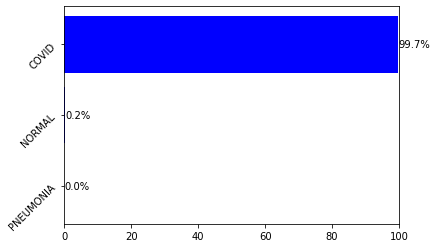

tf.Tensor([[9.9995732e-01 2.1152093e-05 2.1607531e-05]], shape=(1, 3), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([0.9999573], shape=(1,), dtype=float32)
tf.Tensor(
[[[[-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   ...
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]]

  [[-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08  5.2250215e-07]
   [-2.7505580e-08  1.5952260e-07 -7.8245151e-08 ...  1.0373347e-07
    -8.5228351e-08 

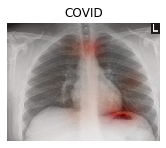

In [21]:
from keras.applications.inception_resnet_v2 import preprocess_input
import random

img_size = (299, 299)
iter = 1
# plt.figure(figsize=(16,iter*3))
predictY = []
realY = []


for i in range(iter):
    # The local path to our target image
    img_path = '../test/negative/normal18.jpg'
    real_y = img_path.split('/')[-2]

    # prediction
    prediction = predict_CXR(img_path)

#     Generate class activation map
    heatmap = make_gradcam_heatmap(img_path, model, feature_model)
    # Calss Activation Map with image
    cam_image = show_CAM(img_path, heatmap, prediction)
    plt.subplot(iter, 2, i+1)
    plt.imshow(cam_image)
    plt.title(prediction)
    plt.axis('off')

    #  # Save the superimposed image
    save_path = "CXR_cam.jpg"
    cam_image.save(save_path)

    predictY.append(prediction)
    realY.append(real_y)
    print(prediction, real_y)
    # print(prediction)
    



이미지 전처리 방법 --- opencv의 resize는 오류가 발생(colab에서는 잘 돌아감)


(299, 299, 3)


(-0.5, 298.5, 298.5, -0.5)

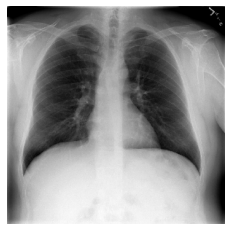

In [ ]:
img_path = random.choice(valid_generator.filepaths)
img_size = (299, 299)
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
img = keras.preprocessing.image.img_to_array(img)
print(img.shape)
img = keras.preprocessing.image.array_to_img(img)
plt.imshow(img)

plt.axis('off')

In [ ]:
import os
def predict_CXR(image_path, model, feature_model):

    img_size = (299, 299)
    
    # image = Image.open(image_path)
    # image_type = image.filename.split('.')[-1] # 확장자
    # print(image_type)
    # image_dir = image.filename.split('.')[0] # 파일 디렉토리
    # if str.lower(image_type) != 'jpg':
    #     image = image.convert("RGB")
    #     new_dir = image_dir + '.jpg'
    #     image.save(  new_dir , 'jpeg')
    #     os.remove(image_path)
    #     image_path = new_dir  # 새로운 확장자 디렉토리
    #     print(new_dir)
    real_y = image_path.split('/')[-2]
    if real_y == 'ViralPneumonia' or real_y =='BacterialPneumonia':
        real_y = 'PNEUMONIA'
    elif real_y == 'Normal':
        real_y = 'NORMAL'
    elif real_y == 'COVID-19':
        real_y = 'COVID'

    

    # 이미지 불러오기 및 이미지 크기 조정   
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)
    # feature_model에서 feature 추출
    feature_vector = feature_model.predict(img)
    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    # print(prediction)
    unique_sorted_Y = ['COVID19','NORMAL','PNEUMONIA']

    top_3_predict = prediction.argsort()[::-1][:3]
    # print(top_3_predict)
    #labels에 저장 
    labels = [unique_sorted_Y[index] for index in top_3_predict]
    # color = ['blue'] * 3


    # # show portion
    # text = []
    # text = prediction[top_3_predict][::-1] * 100
    # # print(text)
    # rects = plt.barh(range(3), text, color = color)
    # plt.yticks(np.arange(3), labels[::-1], rotation=45)
    # plt.xlim(0,100)

    # # plt.rc('font', size=10)
    # for i, rect in enumerate(rects):
    #     plt.text(rect.get_width(), rect.get_y() + rect.get_height() / 2.0, str(round(text[i], 1)) + '%', ha='left', va='center')

    # plt.show()
    # plt.draw()
    # plt.savefig('media/prediction_plot.jpg')
    # plot = keras.preprocessing.image.load_img('media/prediction_plot.jpg')
    # os.remove('media/prediction_plot.jpg')
    # plt.clf()

    # os.remove(image_path)
    print(labels[0], real_y)
    return labels[0]


iter = 100
for i in range(iter):
    img_path = random.choice(valid_generator.filepaths)
    # img_path = '/content/lobar-pneumonia.jpg'
    prediction = predict_CXR(img_path, model, feature_model)
    # print(prediction)

In [ ]:
model = load_model('/content/drive/My Drive/인공지능 학습관련/covid_model_size299_4_best')